In [65]:
import os
import typing

import numpy as np
import pandas as pd
from scipy.stats import rankdata
from itertools import product,combinations,chain
from models import bt_plot,model,glrt
from dataset_management import get_dataset
from pymer4.models import Lmer


pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)
fig5_df=get_dataset(dataset_name="fig5_24_at25_bad_intsteps")

In [66]:
algos=["1","2","3"]
seeds=list(range(50))
benchmarks=["0","2","3","4"]
budgets=[1,2]

combination = list(product(algos, benchmarks, [0],seeds,budgets))
random_df = pd.DataFrame(combination, columns=["algorithm", "benchmark", "value", "seed","budget"])
def gen_value_rand(row):
    return np.random.normal(0, 0.1)
random_df["value"] = random_df.apply(gen_value_rand, axis=1)
random_df["seed"]=random_df["seed"].astype('str')


In [74]:

class model_builder():
    def __init__(self,df:pd.DataFrame,loss_var:str="value",system_var="algorithm",benchmark_var="benchmark",features:typing.List[str]=[],factors:typing.List[str]=[]):
        self.df=df
        self.loss_formula=f"{loss_var} ~ "
        self.features=features
        self.included_features=["algorithm"]
        self.factors=factors
        self.effect_types={"algorithm":"algorithm"}
        self.exploratory_var=system_var
        self.benchmark_var=benchmark_var

    def test_seed_dependency(self):
        simpel_model=model(formula=f"{self.loss_formula}+{self.exploratory_var}",data=self.df,factor_list=[self.exploratory_var],dummy=False)
        seed_model=model(formula=f"{self.loss_formula}+(0+{self.exploratory_var}|seed)",data=self.df,factor_list=[self.exploratory_var],dummy=False)
        test_result=glrt(simpel_model,seed_model,names=["simple","seed"],returns=True)
        if test_result["p"]<0.05 and seed_model.logLike>simpel_model.logLike:
            ranef_var=seed_model.ranef_var
            print(f"Seed is significant, likely influenced algorithms: {ranef_var.loc[(ranef_var['Var']/10 >= ranef_var['Var'].min())&(ranef_var.index!='Residual')&(ranef_var['Var']*10 >= ranef_var['Var'].max())]['Name'].to_list()}")
        else:
            print("Seed is not significant")

    def test_benchmark_information(self):
        benchmark_info={}
        for benchmark in self.df[self.benchmark_var].unique():
            simple_mod=model(formula=f"{self.loss_formula}+1",data=self.df.loc[self.df[self.benchmark_var]==benchmark],factor_list=[self.exploratory_var],dummy=False)
            benchmark_mod=model(formula=f"{self.loss_formula}+{self.exploratory_var}",data=self.df.loc[self.df[self.benchmark_var]==benchmark],factor_list=[self.exploratory_var],dummy=False)
            print(f"\nBenchmark: {benchmark}")
            benchmark_info[benchmark]=glrt(simple_mod,benchmark_mod,names=["simple","algorithm"],returns=True)
            if benchmark_info[benchmark]["p"]<0.05 and benchmark_mod.logLike>simple_mod.logLike:
                print(f"Benchmark {benchmark} is informative.")
            else:
                print(f"Benchmark {benchmark} is uninformative.")
        if any(benchmark_info[b]["p"]>0.05 for b in benchmark_info.keys()):
            if input("Do you want to rank the benchmarks (time-intensive)? (y)")=="y":
                all_benchmarks_mod=model(formula=f"{self.loss_formula}+(0+{self.benchmark_var}|{self.exploratory_var})",data=self.df,factor_list=[self.exploratory_var],dummy=False)
                print(all_benchmarks_mod.ranef_var)

seed_df=pd.DataFrame(combination, columns=["algorithm", "benchmark", "value", "seed","budget"])
seed_df["seed"]=seed_df["seed"].astype('str')
seed_df["value"] = seed_df.apply(lambda row:np.random.normal(int(row["seed"])*0.5 if row["algorithm"] in ["1","2"] and int(row["seed"])%5==0 else 0.5, 0.1), axis=1)

builder=model_builder(random_df,system_var="algorithm",features=["seed"],factors=["algorithm"])
builder.test_seed_dependency()

benchmark_df=pd.DataFrame(combination, columns=["algorithm", "benchmark", "value", "seed","budget"])
benchmark_df["benchmark"]=benchmark_df["benchmark"].astype('str')
benchmark_df["value"]=benchmark_df.apply(lambda row: np.random.normal(0.5*int(row["algorithm"])*int(row["benchmark"]), 0.01), axis=1)

builder=model_builder(benchmark_df,system_var="algorithm",features=["seed"],benchmark_var="benchmark",factors=["algorithm"])
builder.test_benchmark_information()

boundary (singular) fit: see help('isSingular') 

simple (1050.34) == seed (1049.55)
Chi-Square: 1.5787921894429928, P-Value: 0.45411895732546836
Seed is not significant

Benchmark: 0
simple (957.33) == algorithm (959.19)
Chi-Square: 3.718883287189783, P-Value: 0.15575957544917596
Benchmark 0 is uninformative.

Benchmark: 2
simple (-364.79) << algorithm (985.56)
Chi-Square: 2700.7081652233974, P-Value: 0.0
Benchmark 2 is informative.

Benchmark: 3
simple (-486.36) << algorithm (961.18)
Chi-Square: 2895.0957142929838, P-Value: 0.0
Benchmark 3 is informative.

Benchmark: 4
simple (-572.75) << algorithm (958.83)
Chi-Square: 3063.15223961148, P-Value: 0.0
Benchmark 4 is informative.


boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 



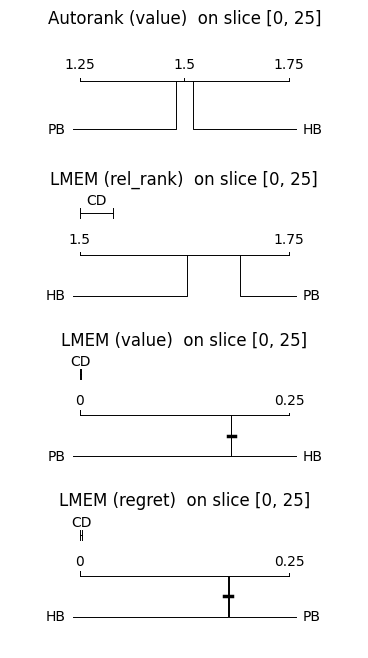

In [68]:
plot_1=bt_plot([[0,25]],rows=4,dataset=fig5_df.loc[(fig5_df["algorithm"]!="RS")&(fig5_df["bench_prior"]=="LC-167190_at25")],algorithm_var="algorithm",budget_var="used_fidelity")
plot_1.change_row(0,None,globality=False,loss="value")
plot_1.change_row(1,f"algorithm",globality=False,loss="rel_rank")
plot_1.change_row(2,f"algorithm",globality=False,loss="value")
plot_1.change_row(3,f"algorithm",globality=False,loss="regret")
plot_1.show()

                            Name         Var        Std
algorithm      benchmarkJAHS-C10  135.685244  11.648401
algorithm       benchmarkJAHS-CH   52.165100   7.222541
algorithm       benchmarkJAHS-FM   35.441897   5.953310
algorithm     benchmarkLC-126026    0.254739   0.504716
algorithm     benchmarkLC-167190    0.125850   0.354753
algorithm     benchmarkLC-168330    0.016117   0.126953
algorithm     benchmarkLC-168910    0.046651   0.215989
algorithm     benchmarkLC-189906    0.143302   0.378552
algorithm  benchmarkPD1-Cifar100    0.045919   0.214287
algorithm  benchmarkPD1-ImageNet    0.065133   0.255213
algorithm      benchmarkPD1-LM1B    0.017931   0.133906
algorithm       benchmarkPD1-WMT    0.016730   0.129346
Residual                           16.604217   4.074827

In [69]:


def test_feature(self,feature:str):
    formulae=[feature,f"(1|{feature})","(0+"+f"{self.exploratory_var}|{feature})","(1+"+f"{self.exploratory_var}|{feature})"]

    base_formula=self.loss_formula+f" + {self.exploratory_var} + ".join([self.effect_types[feature] for feature in self.included_features])
    base_model=model(formula=base_formula,data=self.df,factor_list=["algorithm"],dummy=False)
    base_model=model(formula=base_formula,data=self.df,factor_list=[factor for factor in self.factors if factor in self.included_features],dummy=False)
    new_models:list[Lmer]=[]
    for formula in formulae:

        new_formula=self.loss_formula+" + ".join([self.effect_types[feature] for feature in self.included_features])+f" + {formula}"
        # print(new_formula)
                                                
        new_models.append(model(formula=new_formula,data=self.df,factor_list=[factor for factor in self.factors if factor in self.included_features+[feature]],dummy=False))
        print(new_models[-1].summary())
        if type(new_models[-1]) is Lmer:
            print(new_models[-1].ranef)
            print(new_models[-1].ranef_var)
        
    test_results=glrt(base_model,new_models[0],names=["baseline",f"baseline + {feature}"],returns=True)
    test_results=glrt(new_models[0],new_models[1],names=[f"baseline + {feature}",f"baseline + {formulae[1]}"],returns=True)
    test_results=glrt(new_models[0],new_models[2],names=[f"baseline + {feature}",f"baseline + {formulae[2]}"],returns=True)
    test_results=glrt(new_models[0],new_models[3],names=[f"baseline + {feature}",f"baseline + {formulae[3]}"],returns=True)
    test_results=glrt(new_models[1],new_models[2],names=[f"baseline + {formulae[1]}",f"baseline + {formulae[2]}"],returns=True)
    test_results=glrt(new_models[1],new_models[3],names=[f"baseline + {formulae[1]}",f"baseline + {formulae[3]}"],returns=True)
    test_results=glrt(new_models[2],new_models[3],names=[f"baseline + {formulae[2]}",f"baseline + {formulae[3]}"],returns=True)

model_builder.test_feature=test_feature

        # if test_results["p"]<0.05:
        #     print(f"Feature {feature} is significant")

print("############ first case: No seed influence ############")
builder=model_builder(random_df,system_var="algorithm",features=["seed"],factors=["seed","algorithm"])
builder.test_feature(feature="seed")

print("\n ############ second case: Linear seed influence ############")
builder2=model_builder(seed_df,system_var="algorithm",features=["seed"],factors=["seed","algorithm"])
builder2.test_feature(feature="seed")

print("\n ############ third case: Modulo seed influence ############")
builder3=model_builder(seed2_df,system_var="algorithm",features=["seed"],factors=["seed","algorithm"])
builder3.test_feature(feature="seed")


############ first case: No seed influence ############
Formula: value~algorithm+seed

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 1200	 R^2: 0.037	 R^2_adj: -0.006

Log-likelihood: 1072.156 	 AIC: -2040.312	 BIC: -1775.628

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val Sig
Intercept          0.011     NaN      NaN  0.021 -49   0.538    NaN    
algorithm[T.2]    -0.007     NaN      NaN  0.007 -49  -0.935    NaN    
algorithm[T.3]    -0.009     NaN      NaN  0.007 -49  -1.188    NaN    
seed[T.1]          0.007     NaN      NaN  0.029 -49   0.232    NaN    
seed[T.10]         0.007     NaN      NaN  0.029 -49   0.248    NaN    
seed[T.11]         0.019     NaN      NaN  0.029 -49   0.659    NaN    
seed[T.12]         0.010     NaN      NaN  0.029 -49   0.343    NaN    
seed[T.13]        -0.044     NaN      NaN  0.029 -49  -1.508    NaN    
seed[T.14]         0.009     NaN

NameError: name 'seed2_df' is not defined